In [1]:
import numpy as np
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style
from sklearn.model_selection import train_test_split
import tensorflow as tf
from matplotlib import pyplot as plt
import keras_tuner as kt
from keras_tuner import HyperParameters
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn import model_selection

In [2]:
X_train = pd.read_csv(here('data/processed/X_train_scaled.csv'))
print(X_train.shape)
y_train = pd.read_csv(here('data/processed/Y_train.csv'))
print(y_train.shape)


X_val = pd.read_csv(here('data/processed/X_val_scaled.csv'))
print(X_val.shape)
y_val = pd.read_csv(here('data/processed/Y_val.csv'))
print(y_val.shape)

(7499, 6)
(7499, 6)
(1501, 6)
(1501, 6)


Machine failure
0    1451
1      50
Name: count, dtype: int64


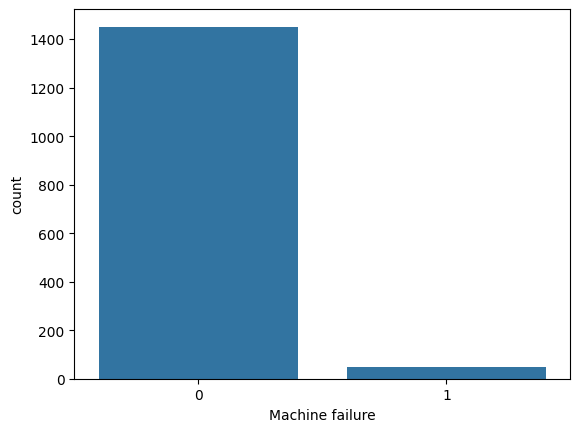

In [15]:
sns.barplot(y_val['Machine failure'].value_counts())
print(y_val['Machine failure'].value_counts())

In [16]:
#Setting interested failure mode
y_machine_failure = y_val['Machine failure']

In [ ]:
def build_model(num_features, learning_rate):
  """Build a TF linear regression model using Keras.

  Args:
    num_features: The number of input features.
    learning_rate: The desired learning rate for SGD.

  Returns:
    model: A tf.keras model (graph).
  """
  # This is not strictly necessary, but each time you build a model, TF adds
  # new nodes (rather than overwriting), so the colab session can end up
  # storing lots of copies of the graph when you only care about the most
  # recent. Also, as there is some randomness built into training with SGD,
  # setting a random seed ensures that results are the same on each identical
  # training run.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  # Build a model using keras.Sequential. While this is intended for neural
  # networks (which may have multiple layers), we want just a single layer for
  # linear regression.
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(
      units=1,        # output dim
      input_shape=(num_features,), # input dim
      use_bias=True,               # use a bias (intercept) param
      kernel_initializer=tf.ones_initializer,  # initialize params to 1
      bias_initializer= tf.ones_initializer,    # initialize bias to 1
  ))

  # We need to choose an optimizer. We'll use GD, which is actually mini-batch GD
  optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

  # Finally, compile the model. This finalizes the graph for training.
  # We specify the MSE loss and the optimizer above
  model.compile(
    optimizer=optimizer,
    loss='mse'
  )
    
  return model

In [ ]:
tf.random.set_seed(0)
# 2. Build and compile model
# YOUR CODE HERE
epoch=5
model_tf = build_model(X_train_std.shape[1], learning_rate=0.0001)
# 3. Fit the model
# YOUR CODE HERE
print(X_train_std.shape,Y_train_std.shape)

print(X_val_std.shape, Y_val_std.shape)
baseline_fit = model_tf.fit(X_train_std,
                            Y_train_std,
                            epochs=epoch,
                            validation_data=(X_val_std,Y_val_std))
print(baseline_fit)
loss = baseline_fit.history['loss']
print(loss)